In [1]:
library (edgeR)
library (tidyverse)
library (openxlsx)
library (magrittr)
library (ggrepel)
library (reshape2)
library (readr)

Loading required package: limma

── Attaching packages ────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
fig <- function(width, heigth){
options(repr.plot.width = width, repr.plot.height = heigth) }

In [3]:
getwd()

[1] "/research/groups/RawdataCarlberg/2022_Doseresponse-final"

In [4]:
load(file = "data/x_proteincoding.RData")

> Decision to exclude 1 nM 1,25D 04 h and 08 h samples (6 samples) after DGE analysis was performed. DGE-Analysis was not repeated, but for visualization purposes (MDS plot) DGE pipeline performed without the 6 samples

In [5]:
x = x %>%
select (., -c(V125D3_1nM_4h_R1:V125D3_1nM_8h_R3))

In [6]:
colnames(x) <- gsub("_4h","_04h",as.character(colnames(x)))
colnames(x) <- gsub("_8h","_08h",as.character(colnames(x)))

In [7]:
#sort colnames
x = x[ , order(names(x))]

In [8]:
x = x %>% 
  round ()

In [9]:
#str(x, list.len=ncol(x))

# Operation sampleinfo

In [10]:
sampleinfo = as.vector (colnames (x))
sampleinfo <- reshape2::colsplit(sampleinfo, "_", c("compound", "concentration","time","replicate")) #,"pool" pool is confounded with biology ?
sampleinfo <- as.data.frame(unclass(sampleinfo))
#sampleinfo

In [11]:
sampleinfo$sample <- colnames (x)
Group <- factor(paste(sampleinfo$compound, sampleinfo$concentration, sampleinfo$time, sep="_"))
sampleinfo = cbind(sampleinfo,Group=Group)#, Group2=Group2)
#sampleinfo

In [12]:
table(colnames(x)==sampleinfo$sample)


TRUE 
  66 

In [13]:
y <- DGEList (counts =x, group = Group, genes = rownames (x))
head (y$counts)
#y$samples

,EtOH_x_04h_R1,EtOH_x_04h_R2,EtOH_x_04h_R3,EtOH_x_08h_R1,EtOH_x_08h_R2,EtOH_x_08h_R3,EtOH_x_24h_R1,EtOH_x_24h_R2,EtOH_x_24h_R3,V125D3_0.1nM_24h_R1,⋯,V25D3_100nM_24h_R3,V25D3_250nM_24h_R1,V25D3_250nM_24h_R2,V25D3_250nM_24h_R3,V25D3_500nM_24h_R1,V25D3_500nM_24h_R2,V25D3_500nM_24h_R3,V25D3_750nM_24h_R1,V25D3_750nM_24h_R2,V25D3_750nM_24h_R3
EEF1A1,37846,35744,29848,41801,61262,67443,60776,36756,46582,57886,⋯,43091,25409,22843,57377,55799,29250,45732,70411,48950,23126
THBS1,42044,39283,28412,56997,82207,70708,21645,11172,20194,60399,⋯,25624,19140,10146,32297,1746,1501,2099,2188,1568,652
AHNAK,19041,17841,14409,24314,35440,40691,32367,20048,31599,35368,⋯,22532,13910,12039,29595,24406,12939,19461,28051,18860,10170
ACTB,13456,12195,10414,19043,27443,27814,54916,28940,35311,41755,⋯,42316,22888,15615,45978,20795,10764,16951,24917,15899,8425
HLA-B,15298,14933,12659,17392,25332,28814,27600,16239,20550,24743,⋯,21185,12147,10923,28545,25048,13672,21049,32761,21154,11332
FTH1,14522,13259,11156,19831,28909,31354,45559,24433,32383,37053,⋯,31154,17514,12758,39859,15217,8751,13293,16888,12036,5483


In [14]:
df <- data.frame(sample = (rownames(y$samples)), 
                 readcountsums = y$samples$lib.size, 
                 group = y$samples$group) 

str (df)

'data.frame':	66 obs. of  3 variables:
 $ sample       : chr  "EtOH_x_04h_R1" "EtOH_x_04h_R2" "EtOH_x_04h_R3" "EtOH_x_08h_R1" ...
 $ readcountsums: num  4229233 3953733 3211283 5252411 7629980 ...
 $ group        : Factor w/ 22 levels "EtOH_x_04h","EtOH_x_08h",..: 1 1 1 2 2 2 3 3 3 4 ...


In [15]:
keep <- filterByExpr(y)
table(keep)

keep
FALSE  TRUE 
 6192 12950 

In [16]:
y <- y[keep, , keep.lib.sizes=FALSE]

In [17]:
y <- calcNormFactors(y, method = "TMM") #default in TMM
#y$samples

In [18]:
df <- data.frame(sample = (rownames(y$samples)), 
                 readcountsums = y$samples$lib.size, 
                 group = y$samples$group) 

str (df)

'data.frame':	66 obs. of  3 variables:
 $ sample       : chr  "EtOH_x_04h_R1" "EtOH_x_04h_R2" "EtOH_x_04h_R3" "EtOH_x_08h_R1" ...
 $ readcountsums: num  4226545 3951350 3209084 5249047 7625041 ...
 $ group        : Factor w/ 22 levels "EtOH_x_04h","EtOH_x_08h",..: 1 1 1 2 2 2 3 3 3 4 ...


In [19]:
#write.xlsx (df, "./libsizes_internal.xlsx")

In [20]:
#ggsave(plot = p, filename = "./libsizes_plot_internalcheck.pdf", device = "pdf", width = 10, height = 15)

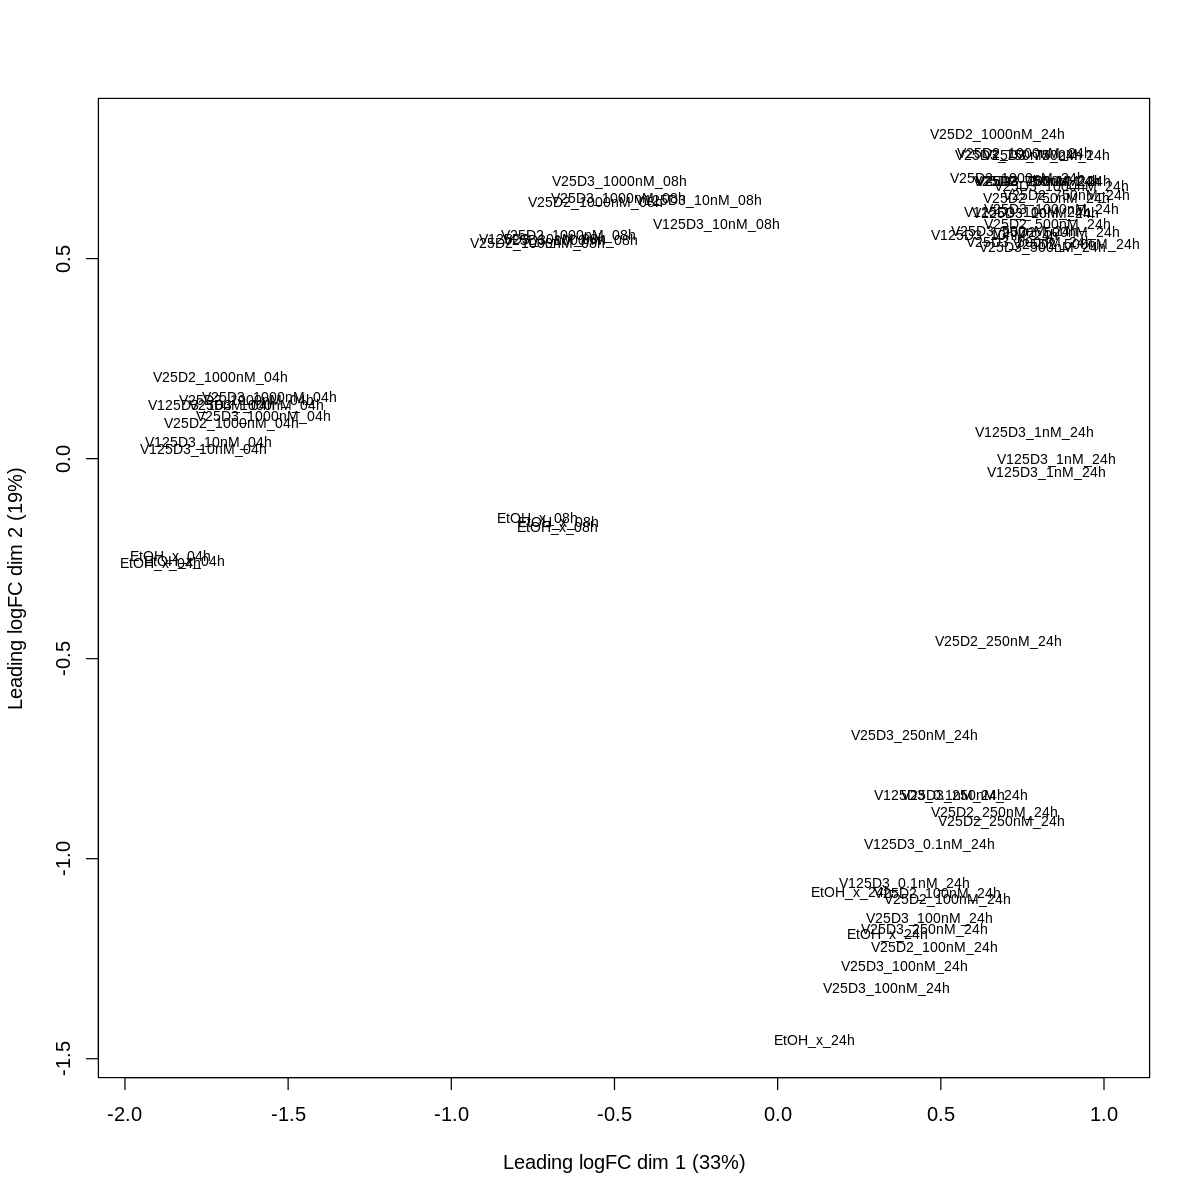

In [21]:
fig(10,10)

MDS = plotMDS(y, cex = 0.7, labels=sampleinfo$Group)

variance explained:

In [22]:
round (0.333793816835076, 3)
round (0.187169495783946, 3)

[1] 0.334

[1] 0.187

In [23]:
MDS_Treatmentplot <- data.frame(MDS$x, MDS$y)

In [24]:
tail(sampleinfo)

,compound,concentration,time,replicate,sample,Group
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
61,V25D3,500nM,24h,R1,V25D3_500nM_24h_R1,V25D3_500nM_24h
62,V25D3,500nM,24h,R2,V25D3_500nM_24h_R2,V25D3_500nM_24h
63,V25D3,500nM,24h,R3,V25D3_500nM_24h_R3,V25D3_500nM_24h
64,V25D3,750nM,24h,R1,V25D3_750nM_24h_R1,V25D3_750nM_24h
65,V25D3,750nM,24h,R2,V25D3_750nM_24h_R2,V25D3_750nM_24h
66,V25D3,750nM,24h,R3,V25D3_750nM_24h_R3,V25D3_750nM_24h


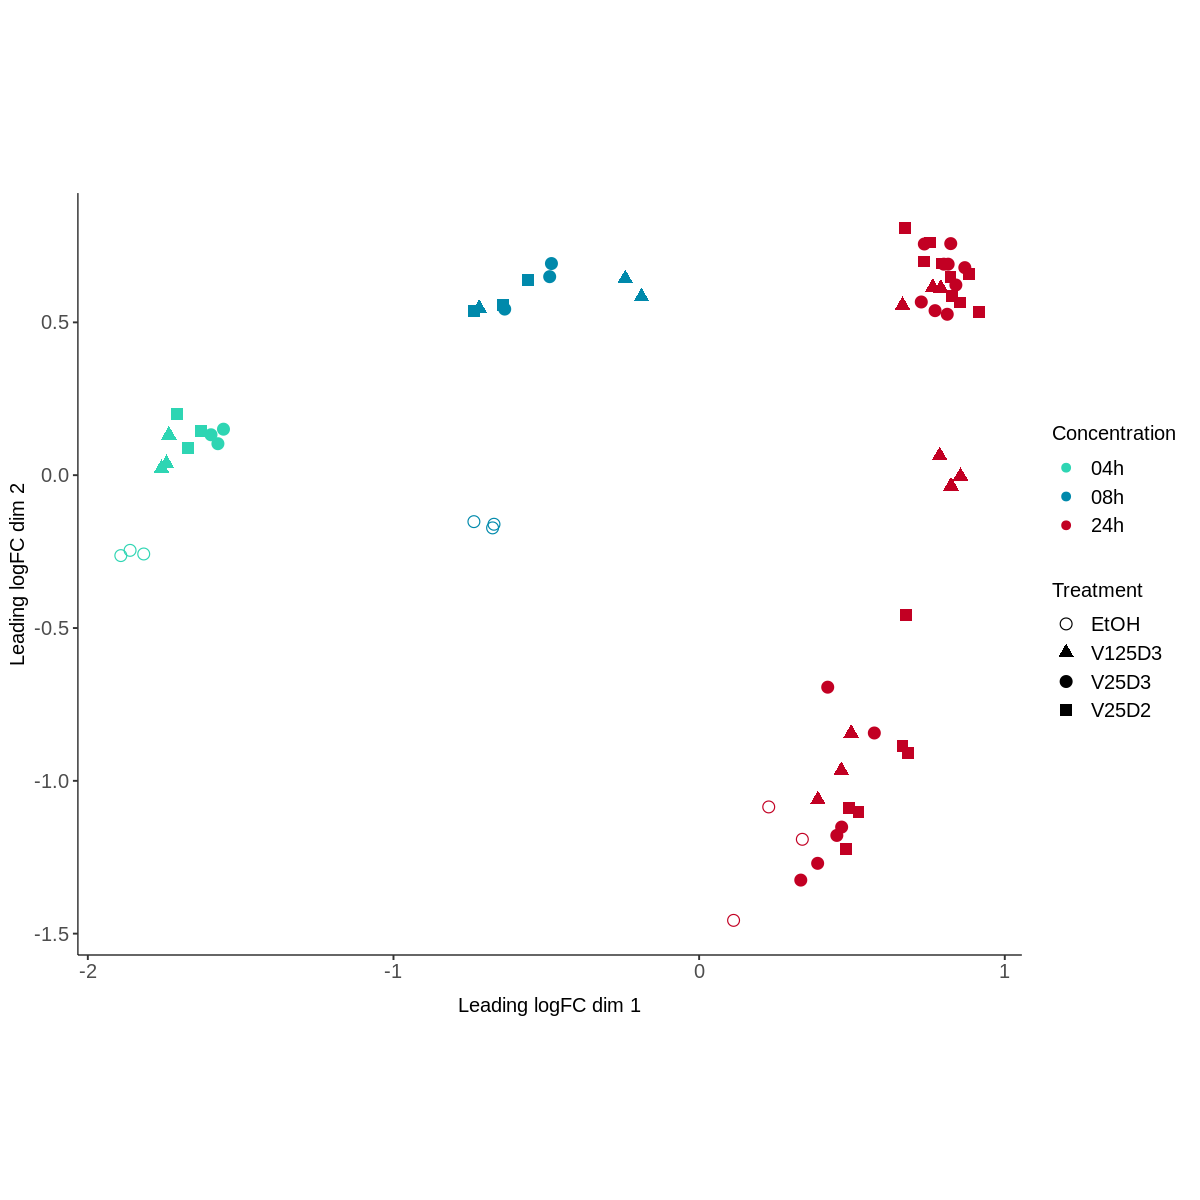

In [25]:
MDS = ggplot(MDS_Treatmentplot, 
             aes(x = MDS.x, 
                 y = MDS.y,
                 color=sampleinfo$time, 
                 shape = sampleinfo$compound,
                 label = sampleinfo$Group
                
        )) +  #sample
  geom_point(size =3, alpha = 1) +
  xlab(paste0("Leading logFC dim 1")) +
  ylab(paste0("Leading logFC dim 2")) +

  coord_fixed(ratio =1)+  
        scale_shape_manual(values=c(
                   "EtOH" = 1,
       "V125D3" = 17,
         "V25D3" = 19,
         "V25D2" = 15#,
 
        ))+

scale_color_manual(values = c(
    '04h'="#2ED5B3",
    '08h'="#0089AB",
    '24h'="#C20023"#, 
))+ #

  theme_classic(base_size = 12,base_family = "sans")+  #classic
  theme(axis.text=element_text(size=12), 
        axis.title=element_text(size=12), #, face = "bold"

        legend.title = element_text(color = "black", size = 12),
        legend.text = element_text(color = "black", size = 12))+
  labs(
    colour = "Concentration",
    shape = "Treatment"
  )+
  guides(color=guide_legend(title="Concentration", override.aes = list(size = 2.1))) +
  theme(axis.title.x = element_text(vjust=-1)) +
  theme( 
    legend.title = element_text(color = "black", size = 12),
    legend.text = element_text(color = "black", size = 12),
    axis.line.x = element_line(size = 0.33),
    axis.line.y = element_line(size = 0.33))+
  guides(fill = guide_legend(reverse=TRUE))

MDS

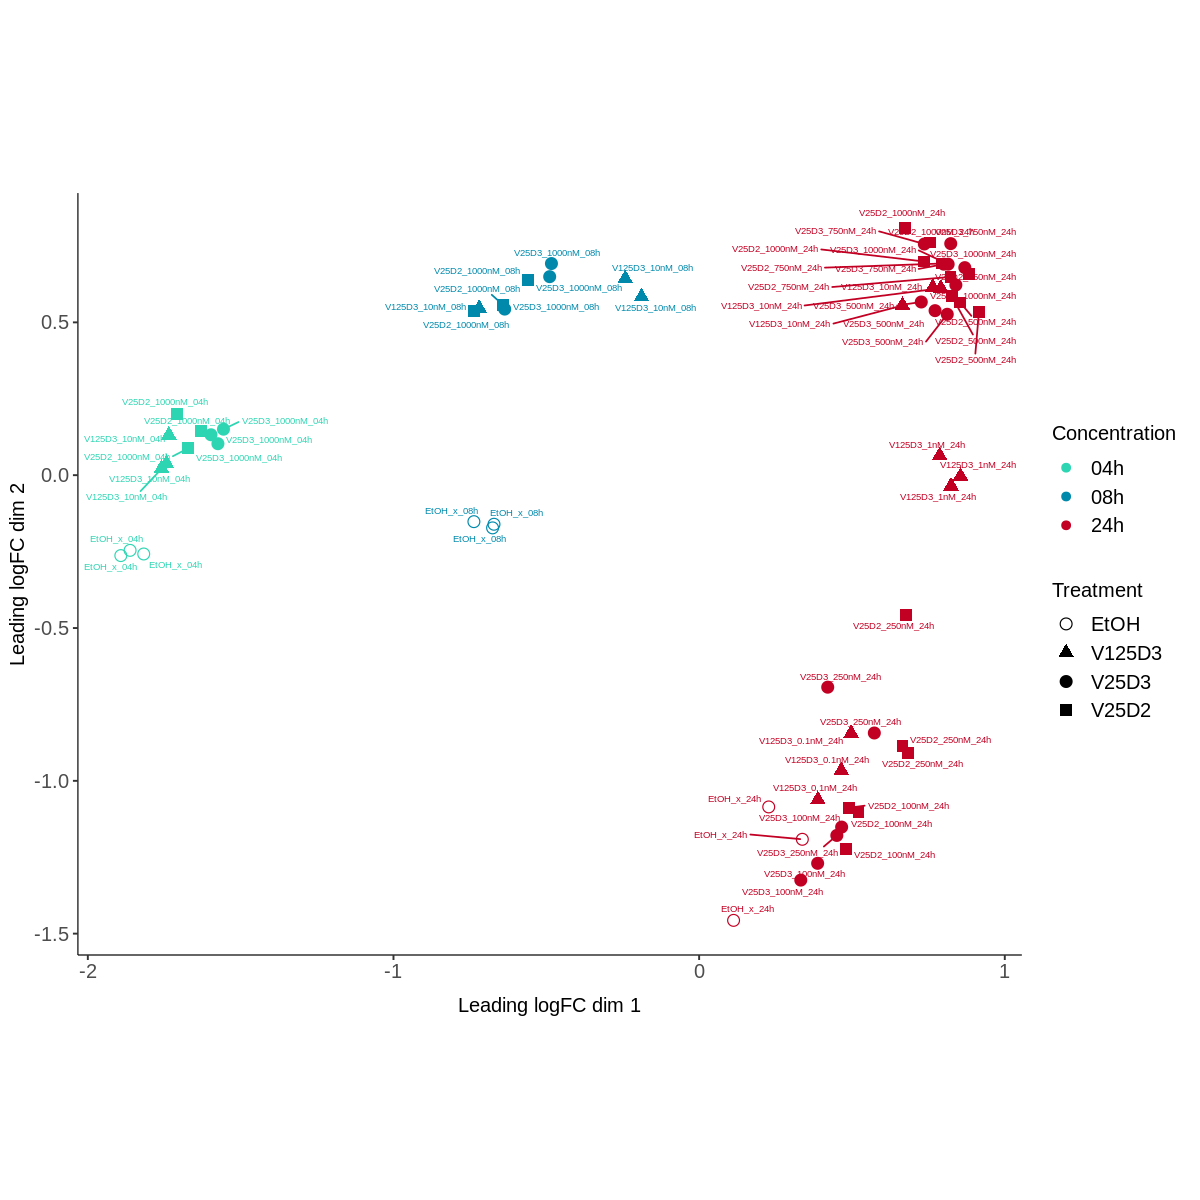

In [26]:
MDS2 = MDS + geom_text_repel(size =2, max.overlaps = Inf)
#MDS2
MDS2

In [27]:
#ggsave("./plots/MDS_bytime.pdf", plot = MDS, width = 9, height = 9)

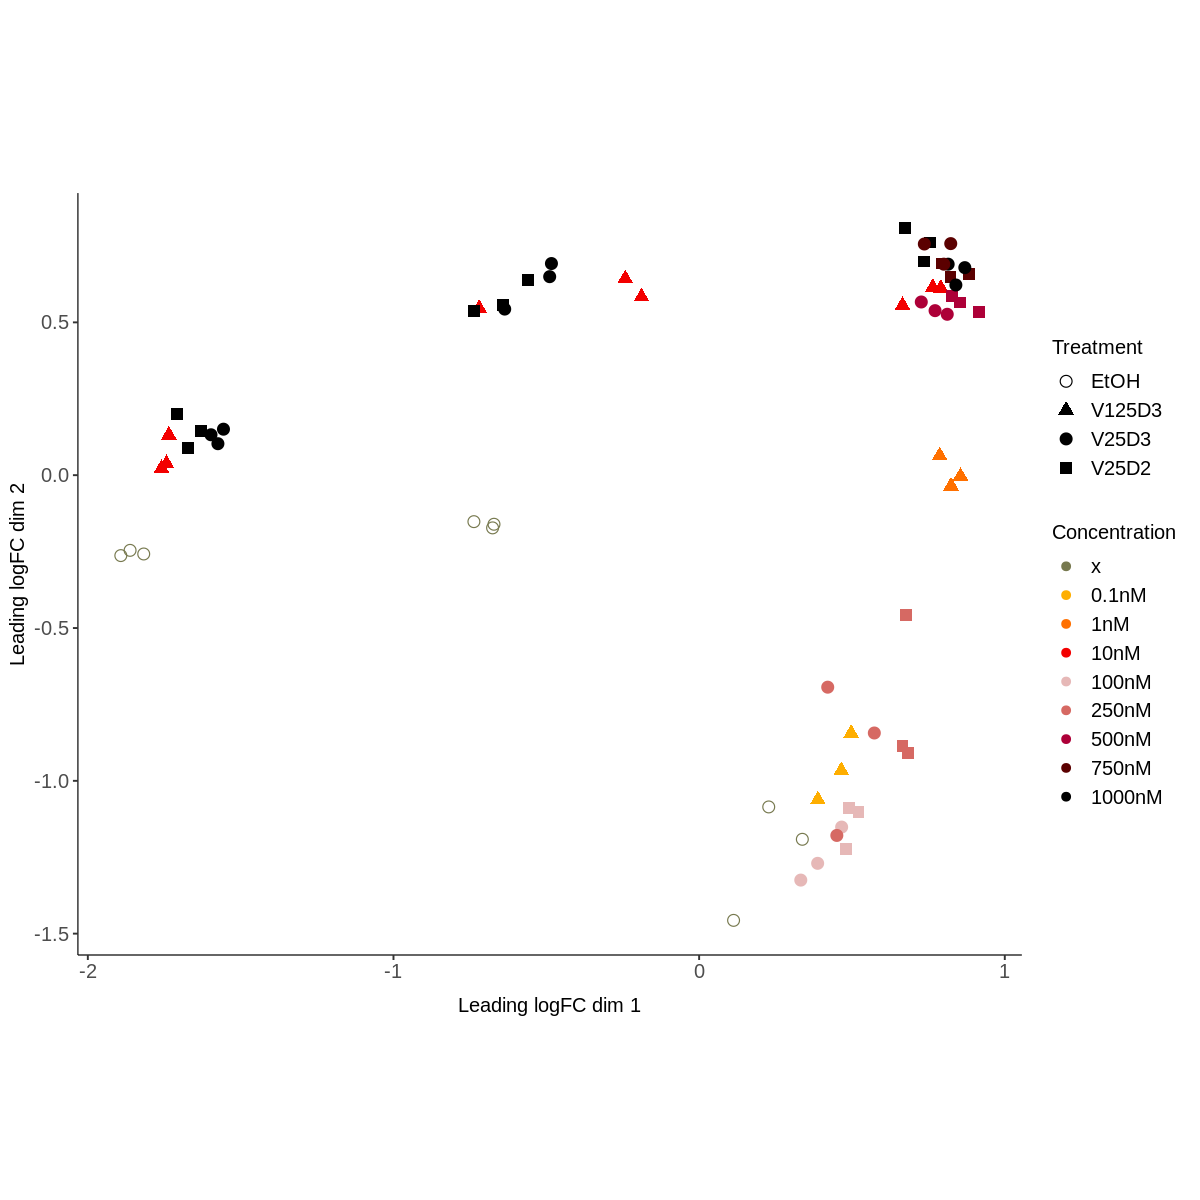

In [28]:
MDS = ggplot(MDS_Treatmentplot, 
             aes(x = MDS.x, 
                 y = MDS.y,
                 color=sampleinfo$concentration, 
                 shape = sampleinfo$compound,
                 label = sampleinfo$Group
                
        )) +  #sample
  geom_point(size =3, alpha = 1) +
  xlab(paste0("Leading logFC dim 1")) +
  ylab(paste0("Leading logFC dim 2")) +

  coord_fixed(ratio =1)+   #there must be a better way than random number!
 
        scale_shape_manual(values=c(
                   "EtOH" = 1,
       "V125D3" = 17,
         "V25D3" = 19,
         "V25D2" = 15#,

        ))+
scale_color_manual(values = c(
    'x'="#77794F", 
                              '0.1nM'="#FEAE00",
                              '1nM'="#FF7000",
                              '10nM'="#F30000",
                              '100nM'="#E6B8B7",
                              '250nM'="#D66963",
                              '500nM'="#AD0038",
                              '750nM'="#5B0000",
                              '1000nM'="black"))+ #

  theme_classic(base_size = 12,base_family = "sans")+  #classic
  theme(axis.text=element_text(size=12), 
        axis.title=element_text(size=12), #, face = "bold"

        legend.title = element_text(color = "black", size = 12),
        legend.text = element_text(color = "black", size = 12))+
  labs(
    colour = "Concentration",
    shape = "Treatment"
  )+
  guides(color=guide_legend(title="Concentration", override.aes = list(size = 2.1))) +
  theme(axis.title.x = element_text(vjust=-1)) +
  theme( 
    legend.title = element_text(color = "black", size = 12),
    legend.text = element_text(color = "black", size = 12),
    axis.line.x = element_line(size = 0.33),
    axis.line.y = element_line(size = 0.33))+
  guides(fill = guide_legend(reverse=TRUE))

MDS

In [29]:
ggsave("./plots/MDS_CA2021_byconc.pdf", plot = MDS, width = 9, height = 9)

In [30]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.5 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /research/users/andreha/miniconda3/envs/Mamba-14/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=C.UTF-8           LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] reshape2_1.4.4  ggrepel_0.9.1   magrittr_2.0.1  openxlsx_4.2.5 
 [5] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.7     purrr_0.3.4    
 [9] readr_2.1.1     tidyr_1.1.4     tibble_3.1.6    ggplot2_3.3.5  
[13] tidyverse_1.3.1 edgeR_3.36.0    limma_3.50.0   

loaded via a nam